# Задание 1

Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

Генерируем набор данных с помощью sklearn.datasets.make_regression

In [2]:
data, target, coef = datasets.make_regression(n_samples = 1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)

In [3]:
coef

array([62.6735955, 68.0472182])

In [4]:
target_pred_default = data @ coef

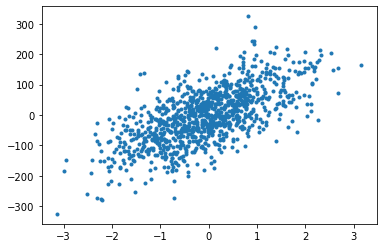

In [5]:
plt.plot(data[:,0], target, '.')
plt.show()

Функция для вычисления среднеквадратичной ошибки:

In [6]:
def calc_mse(target, target_pred):
    err = np.mean((target - target_pred) ** 2)
    return err

In [7]:
mse_default = calc_mse(target, target_pred_default)
mse_default

26.599898646826645

Стандартизация признаков:

In [8]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i][j] = (data[i][j] - means[j])/stds[j]

Градиентный спуск:

In [9]:
def grad_desc(data, target, alpha=1e-02, verbose=False, tol=0.0):

    n = data.shape[0]
    coef = np.random.randn(data.shape[1], )
    min_err = float('inf')
    n_iter = 0
    stop_chek = True
    errors = []
    while stop_chek:
        n_iter += 1
        target_pred = coef @ data.T
        err = calc_mse(target, target_pred)
        errors.append(err)
        if min_err - err > tol:
            min_err = err
        else:
            print(
                f'В случае использования градиентного спуска:\nКоличество итераций: {n_iter}\nВеса: {coef}\nMSE: {min_err}')
            stop_chek = False
        coef -= alpha * (1 / n * 2 * np.sum(data.T * (target_pred - target), axis=1))
    return coef, min_err, errors

In [10]:
coef1, min_err1, errors1 = grad_desc(data, target, alpha=0.01, tol=0.00001)

В случае использования градиентного спуска:
Количество итераций: 439
Веса: [61.42522583 67.65376378]
MSE: 38.56850977329354


Новая функция для вычисления среднеквадратичной ошибки:

In [11]:
def mserror(data, coef, target):
    targ_pred = data.dot(coef)
    return (sum((target - targ_pred)**2)) / len(target)

Стохастический градиентный спуск:

In [12]:
w = np.zeros(2)
w_list = [w.copy()]
errors = []
eta = 0.5
max_iter = 6000
min_weight_dist = 1e-8
weight_dist = np.inf
iter_num = 0
 
np.random.seed(1234)
 
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    train_ind = np.random.randint(data.shape[0])
    
    new_w = w - 2 * eta * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind])) / target.shape[0]
 
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    errors.append(mserror(data, new_w, target))
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)
 
print(f'В случае использования стохастического градиентного спуска:\nКоличество итераций: {iter_num}\nВеса: {w}\nMSE: {errors[-1]}')

В случае использования стохастического градиентного спуска:
Количество итераций: 6000
Веса: [61.08839193 67.35152895]
MSE: 38.782405232436005


График уменьшения MSE в обоих случаях

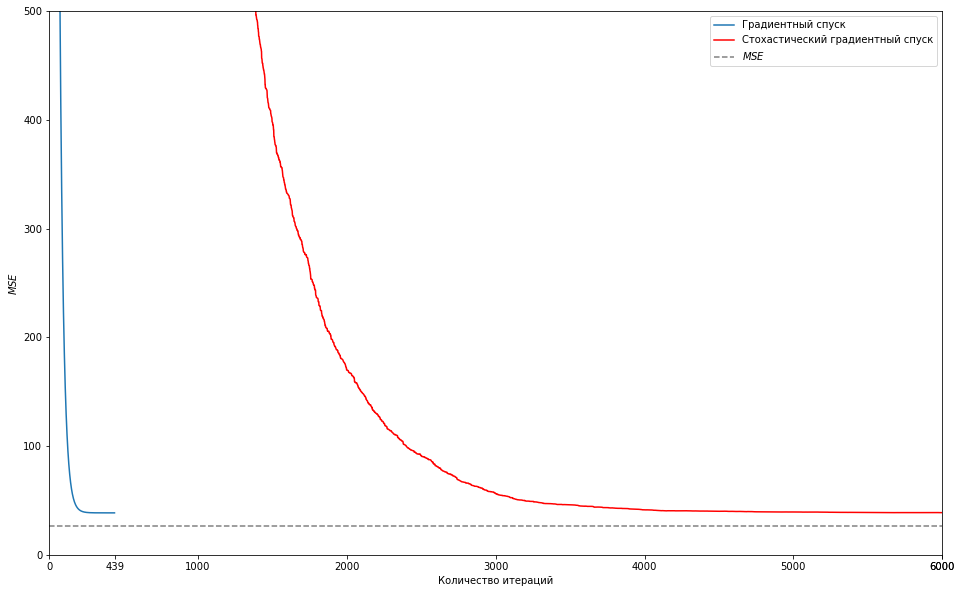

In [13]:
plt.figure(figsize=(16, 10))
plt.ylim((0,500))
plt.xlim((0,len(errors)))
plt.plot([x for x in range(len(errors1))], errors1, label='Градиентный спуск')
plt.plot([x for x in range(len(errors))], errors, c='r', label='Стохастический градиентный спуск')
plt.axhline(mse_default, c='gray', ls='--', label=r'$MSE$', mew=0.9)
plt.xlabel('Количество итераций')
plt.xticks(list(plt.xticks()[0])+[len(errors1), len(errors)])
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()

Мы видим, что по методу градиентного спуска модель обучается быстрее, чем по методу СГС, также более резко уменьшается MSE.

# Задание 2

Модифицировать решение первого задания путем добавления  𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

Задаем функцию L2 регуляризации:

In [14]:
def euclid(vec):
    norm=0
    for i in vec:
        norm+=i**2
    return norm**0.5

In [15]:
def sgd_reg(data, target, alpha=1e-04, batch_size=1, n_epoch=1e+06, verbose=False, tol=0.0, lambda_=0.0):

    n = data.shape[0]
    coef = np.random.randn(data.shape[1], )
    n_batch = n // batch_size 
    if n % batch_size != 0:
        n_batch += 1
    min_err = float('inf')
    n_iter = 0 
    stop_chek = True 
    errors = [] 
    while stop_chek:
        n_iter += 1
        for b in range(n_batch):
            start_ = batch_size * b
            end_ = batch_size * (b + 1)
            data_tmp = data.T[:, start_: end_]
            target_tmp = target[start_: end_]
            target_pred = coef @ data_tmp
            err = calc_mse(target_tmp, target_pred)+lambda_*euclid(coef)
            coef -= alpha * (1 / n * 2 * (target_pred - target_tmp) @ data_tmp.T)+lambda_*coef
        errors.append(err)
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, coef, err)
        if n_iter==n_epoch:
            print(
                f'В случае использования стохастического градиентного спуска с L2-регуляризацией:\nКоличество итераций: {n_iter}\nВеса: {coef}\nMSE: {min_err}')
            stop_chek = False
        if np.abs(min_err - err) > tol:         
            min_err = err if err<=min_err else min_err
        else:                               
            print(
                f'В случае использования стохастического градиентного спуска с L2-регуляризацией:\nКоличество итераций: {n_iter}\nВеса: {coef}\nMSE: {min_err}')
            stop_chek = False
        
    return coef, min_err, errors

In [16]:
coef2, mse2, errors2 = sgd_reg(data, target, alpha=0.001, batch_size=1, n_epoch=6000, tol=0.00001, lambda_=0.0000001)

В случае использования стохастического градиентного спуска с L2-регуляризацией:
Количество итераций: 6000
Веса: [58.43429694 64.37378715]
MSE: 3.654640954950222e-05


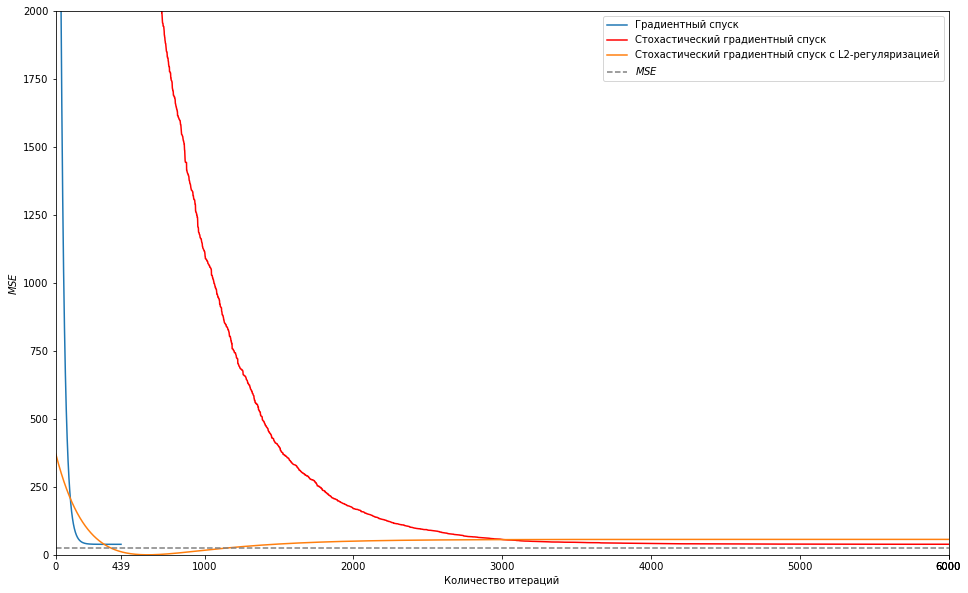

In [17]:
plt.figure(figsize=(16, 10))
plt.ylim((0,2000))
plt.xlim((0,len(errors)))
plt.plot([x for x in range(1, len(errors1) + 1)], errors1, label='Градиентный спуск')
plt.plot([x for x in range(1, len(errors) + 1)], errors, c='r', label='Стохастический градиентный спуск')
plt.plot([x for x in range(1, len(errors2) + 1)], errors2, label='Стохастический градиентный спуск с L2-регуляризацией')
plt.axhline(mse_default, c='gray', ls='--', label=r'$MSE$', mew=0.9)
plt.xticks(list(plt.xticks()[0])+[len(errors1), len(errors), len(errors2)])
plt.xlabel('Количество итераций')
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()